In [20]:
%load_ext autoreload
%autoreload 2

from transformers import AutoTokenizer, RobertaConfig,AutoModel
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

from transfer_bert import PhoBert_transform
from model import LSTM_fixed_len
from train import *
from utils import ReviewsDataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
phobert = AutoModel.from_pretrained("vinai/phobert-base")
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [3]:
max_length = 15

In [4]:
model = PhoBert_transform(tokenizer,phobert,max_length)

# Load data

In [5]:
data_path = '/home/taindp/Jupyter/intent_bert/data'

In [6]:
question = pd.read_csv(os.path.join(data_path,'train_intent_rm_sw.csv'))

In [7]:
question['length'] = [len(item) for item in list(question['content'])]
question['num_word'] = [len(item.split(' ')) for item in list(question['content'])]

(array([37., 66., 29., 20., 13.,  1.,  2.,  5.,  1.,  3.]),
 array([ 5., 11., 17., 23., 29., 35., 41., 47., 53., 59., 65.]),
 <BarContainer object of 10 artists>)

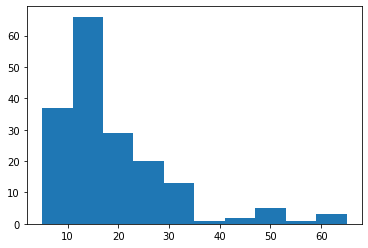

In [8]:
plt.hist(list(question['num_word']), bins = 10)

In [9]:
# max_length = 15
# list_emb_vector = []
# for sent in tqdm(list(question['content']),total = len(list(question['content']))):
#     input_ids = model.tokenizer_list_sentences([sent], max_length)
#     embedding = model.embedding_list_token(input_ids)
#     list_emb_vector.append(embedding)
# question['emb_vector'] = list_emb_vector
# torch.save(question,os.path.join(data_path,'trainset'))

In [10]:
question = torch.load(os.path.join(data_path,'trainset'))

In [11]:
X = list(question['emb_vector'])
y = list(question['label'])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [12]:
# y_train

In [13]:
train_ds = ReviewsDataset(X_train, y_train)
valid_ds = ReviewsDataset(X_valid, y_valid)

In [14]:
# for x,y in train_ds:
#     print(y)

In [15]:
batch_size = 1
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=batch_size)

In [26]:
model_fixed =  LSTM_fixed_len(
                           embedding_dim = 768,\
                           hidden_dim = 100,\
                           num_layers = 2, \
                           bidirectional=True,\
                           dropout=0.5)
model_fixed.cpu()

LSTM_fixed_len(
  (lstm): LSTM(768, 100, num_layers=2, dropout=0.5, bidirectional=True)
  (fc1): Linear(in_features=200, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=1, bias=True)
  (dropout): Dropout(p=0.5)
)

In [27]:
optimizer = torch.optim.Adam(model_fixed.parameters(), lr=0.001)
#     criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()
loss=[]
acc=[]
val_acc=[]
for epoch in range(50):
    train_loss, train_acc = train_model(model_fixed,train_dl,optimizer,criterion)
    valid_acc = evaluate (model_fixed, val_dl)
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Acc: {valid_acc*100:.2f}%')
    
    loss.append(train_loss)
    acc.append(train_acc)
    val_acc.append(valid_acc)

	Train Loss: 0.695 | Train Acc: 50.35%
	 Val. Acc: 63.89%
	Train Loss: 0.695 | Train Acc: 61.70%
	 Val. Acc: 61.11%
	Train Loss: 0.666 | Train Acc: 62.41%
	 Val. Acc: 58.33%
	Train Loss: 0.643 | Train Acc: 60.99%
	 Val. Acc: 69.44%
	Train Loss: 0.611 | Train Acc: 63.83%
	 Val. Acc: 66.67%
	Train Loss: 0.563 | Train Acc: 65.25%
	 Val. Acc: 63.89%
	Train Loss: 0.608 | Train Acc: 63.12%
	 Val. Acc: 63.89%
	Train Loss: 0.578 | Train Acc: 63.12%
	 Val. Acc: 63.89%
	Train Loss: 0.530 | Train Acc: 70.92%
	 Val. Acc: 61.11%
	Train Loss: 0.574 | Train Acc: 67.38%
	 Val. Acc: 61.11%
	Train Loss: 0.561 | Train Acc: 66.67%
	 Val. Acc: 66.67%
	Train Loss: 0.545 | Train Acc: 67.38%
	 Val. Acc: 61.11%
	Train Loss: 0.468 | Train Acc: 75.18%
	 Val. Acc: 58.33%
	Train Loss: 0.531 | Train Acc: 68.79%
	 Val. Acc: 69.44%
	Train Loss: 0.478 | Train Acc: 77.30%
	 Val. Acc: 69.44%
	Train Loss: 0.486 | Train Acc: 70.92%
	 Val. Acc: 58.33%
	Train Loss: 0.505 | Train Acc: 71.63%
	 Val. Acc: 63.89%
	Train Loss: 0